In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely import wkt
from shapely.geometry import box

In [5]:
hood = pd.read_csv('../data/original/hoods.csv')

In [6]:
hood = hood.assign(group = 1,
                   geometry = hood.WKT.map(wkt.loads))

In [7]:
hood = hood.drop(columns=['WKT', 'comuna', 'perimetro', 'area', 'barrio'])

In [13]:
hood = gpd.GeoDataFrame(hood)

In [17]:
cityshape = hood.dissolve(by='group').loc[1, 'geometry']

In [103]:
def fishnet(shape, side, threshold=0.9):
    left, bttm, right, tops = shape.bounds
    xstep = abs(left - right) / side
    ystep = abs(tops - bttm) / side
    
    boxes = []
    
    for i in range(0, side):
        for j in range(0, side):
            minx, maxx = left + (xstep * j), left + (xstep * (j + 1))
            miny, maxy = tops - (ystep * i), tops - (ystep * (i + 1))
            boxes.append(box(minx, miny, maxx, maxy))
            
    def _evaluate_intersect(bxs):
        return list(filter(lambda x: x.intersects(shape), bxs))
    
    def _smooth(bxsc):
        return list(filter(lambda x: (x.intersection(shape).area / x.area) > threshold, bxsc))
    
    
    boxes_contained = _evaluate_intersect(boxes)
    return _smooth(boxes_contained)

In [175]:
citybox = fishnet(cityshape, 80)

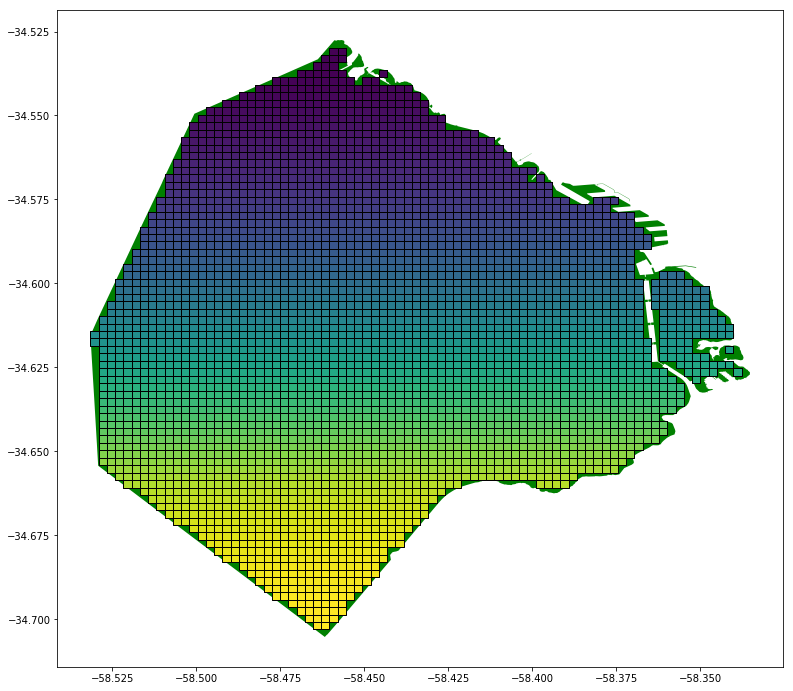

In [178]:
fig, ax = plt.subplots(1,1, figsize=(13,13))
gpd.GeoDataFrame({'geometry':[cityshape]}).plot(color='green', ax=ax)
gpd.GeoDataFrame({'geometry':citybox,'group':range(len(citybox))}).plot(column='group',edgecolor='black',ax=ax)

In [108]:
city = pd.DataFrame({'geometry': citybox})

In [109]:
city.to_csv('../data/city.csv', index=False)

## Add hood info to each box

In [8]:
hood = pd.read_csv('../data/original/hoods.csv')

In [9]:
hood = hood.assign(geometry = hood.WKT.map(wkt.loads), idx = range(len(hood)))

In [10]:
hood = hood.drop(columns=['WKT', 'comuna', 'perimetro', 'area'])

In [138]:
def centroid(shape):
    x, y = shape.centroid.coords[0]
    return wkt.loads(f"POINT ({x} {y})")

In [139]:
city = city.assign(centroid = city.geometry.map(centroid))

In [161]:
def assign_hood(points, hoods):
    assigned = []
    
    def _bounds_index(index_shape):
        i = index_shape[0]
        l, b, r, t = index_shape[1].bounds
        return {'index': i, 'bottom': b, 'right': r, 'top': t, 'left': l}
    
    mirror_hood = list(map(_bounds_index, enumerate(hoods)))
    
    for point in points:
        x, y = point.coords[0]
        targets = list(filter(lambda lim: (lim['left'] < x < lim['right']) & (lim['bottom'] < y < lim['top']), mirror_hood))
        
        for target in targets:
            if hoods[target['index']].contains(point):
                assigned.append(target['index'])
                break
    
    return assigned

In [169]:
city = city.assign(hood = assign_hood(city.centroid.tolist(), hood.geometry.tolist()))

In [176]:
city.to_csv('../data/city.csv', index=False)

In [171]:
geocity = gpd.GeoDataFrame(city)

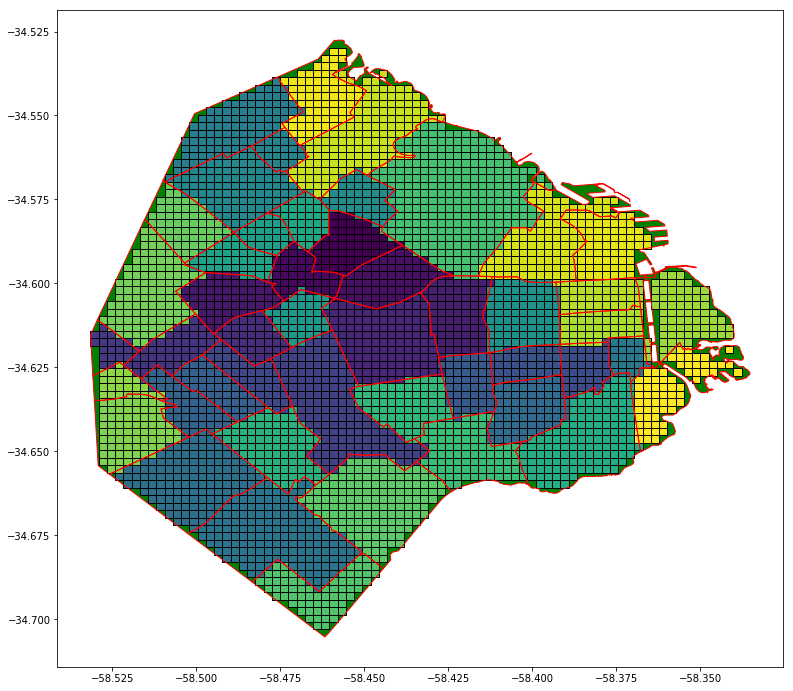

In [174]:
fig, ax = plt.subplots(1,1, figsize=(13,13))
gpd.GeoDataFrame({'geometry':[cityshape]}).plot(color='green', ax=ax)
geocity.plot(column='hood', edgecolor='black', ax=ax)
gpd.GeoDataFrame(hood).plot(edgecolor='red', color='none', ax=ax)

In [13]:
city = pd.read_csv('../data/city.csv')

In [19]:
city = pd.merge(city, hood.loc[:, ['idx', 'barrio']], how='left', left_on='hood', right_on='idx')

In [22]:
city = city.drop(columns=['hood', 'idx']).rename(columns={'barrio': 'hood'})

In [25]:
city.to_csv('../data/city.csv', index=False)